# MS015 Preprocess
Created: 01/25/2025 \
Updated: 04/07/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS015'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [29]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/raw/MS015_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2270079  =      0.000 ...  2216.874 secs...


In [30]:
mne_data

<RawEDF | MS015_SWB.edf, 148 x 2270080 (2216.9 s), ~2.50 GB, data loaded>

In [8]:
# mne_data.ch_names

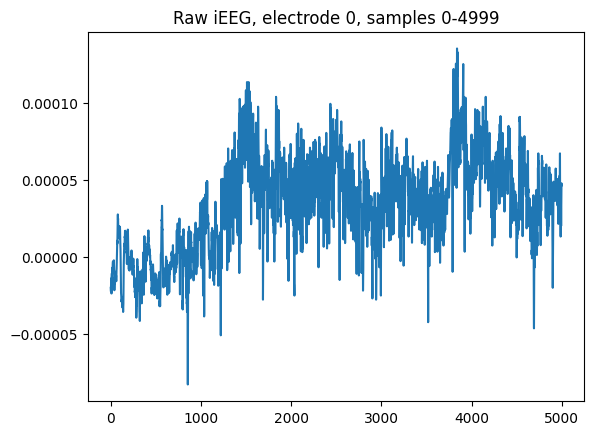

In [8]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [31]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:   27.9s finished


<RawEDF | MS015_SWB.edf, 148 x 1108438 (2216.9 s), ~1.22 GB, data loaded>

### Photodiode
- examine photodiode 

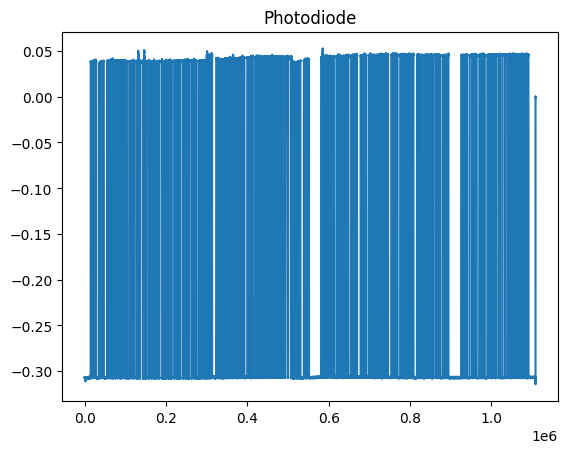

In [32]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [33]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/photodiode.fif
[done]


In [34]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS015_SWB.edf, 147 x 1108438 (2216.9 s), ~1.21 GB, data loaded>

### Notch filter line noise

In [35]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    5.0s finished


<RawEDF | MS015_SWB.edf, 147 x 1108438 (2216.9 s), ~1.21 GB, data loaded>

### Anatomical Localization

In [36]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS015_SWB.edf, 147 x 1108438 (2216.9 s), ~1.21 GB, data loaded>

In [37]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32p_L,-8.138733,42.304521,7.545841,-1.572310,37.114241,15.698201,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus G,WM,NaN
1,LaCaS2,A32p_L,-9.336288,44.302112,11.943495,-3.185345,39.370313,21.088040,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus G,NaN,NaN
2,LaCaS3,A10m_L,-10.933029,46.299702,16.341150,-5.233816,41.692597,26.468540,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 1 A,NaN,NaN
3,LaCaS4,A9m_L,-12.529770,48.297293,19.139657,-7.174913,44.065955,30.065082,White,Left MSFG superior frontal gyrus medial segment,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 1 A,WM,NaN
4,LaCaS5,A9m_L,-14.525696,50.694402,21.138591,-9.262544,46.972420,32.822795,White,Left Cerebral White Matter,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 1 B,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,RpplEm2,Unknown,26.989563,11.541625,20.738804,35.284549,-0.060850,26.587227,White,Right Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
96,RpplEm3,A6cvl_R,31.779785,12.340661,22.737738,41.004437,0.478946,29.285782,White,Right PrG precentral gyrus,Unknown,R Precentral Gyrus,R PrG,Right posterior motor H,WM,NaN
97,RpplEm4,A6cvl_R,36.570007,13.139697,25.136459,46.621959,0.964152,32.420717,Gray,Right PrG precentral gyrus,Unknown,R Precentral Gyrus,R PrG,Right posterior motor H,WM,NaN
98,RpplEm5,A6cvl_R,40.561859,13.938734,27.135393,51.226816,1.560785,35.093795,Gray,Right PrG precentral gyrus,Unknown,R Precentral Gyrus,R PrG,Right posterior motor H,NaN,NaN


In [38]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmOlF1',
 'LmOlF10',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',
 'RAglT6',
 'RAglT7',
 'RAglT8',
 'RaIEm1',
 'RaIEm2',
 'RaIEm3',
 'RaIEm4',
 'RaIEm5',
 'RaIEm6',
 'RaIsT1',
 'RaIsT2',
 'RaIsT3',
 'RaIsT4',
 'RaIsT5',
 'RaIsT6',
 'RHplT1',
 'RHplT10',
 'RHplT11',
 'RHplT12',
 'RHplT2',
 'RHplT3',
 'RHplT4',
 'RHplT5',
 'RHplT6',
 'RHplT7',
 'RHplT8',
 'RHplT9',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RpEm1',
 'RpEm2',
 'RpEm3',
 'RpEm4',
 'RpEm5',
 'RpEm6',
 'RplEm1',
 'RplEm2',
 'RplEm3',
 'RplEm4',
 'RplEm5',
 'RplEm6',
 'RpmEm1',
 'RpmEm2',
 'RpmEm3',
 'RpmEm4',
 'RpmEm5',
 'RpmEm6',
 'RppEm1',
 'RppEm2',
 'RppEm3',
 

In [39]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['rpiem1', 'rpiem2', 'rpiem3', 'rpiem4', 'rpiem5', 'rpiem6', 'ppplem1', 'ppplem2', 'ppplem3', 'ppplem4', 'ppplem5', 'ppplem6', 'abs1', 'abs2', 'chest1', 'chest2', 'c63', 'c64', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c128', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [40]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [41]:
unmatched_seeg #make sure there are no unmatched names


[]

In [42]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [43]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'lmolf10': 'lmolf10',
 'raiem1': 'raiem1',
 'raiem2': 'raiem2',
 'raiem3': 'raiem3',
 'raiem4': 'raiem4',
 'raiem5': 'raiem5',
 'raiem6': 'raiem6',
 'rpmem1': 'rpmem1',
 'rpmem2': 'rpmem2',
 'rpmem3': 'rpmem3',
 'rpmem4': 'rpmem4',
 'rpmem5': 'rpmem5',
 'rpmem6': 'rpmem6',
 'rpem1': 'rpem1',
 'rpem2': 'rpem2',
 'rpem3': 'rpem3',
 'rpem4': 'rpem4',
 'rpem5': 'rpem5',
 'rpem6': 'rpem6',
 'rpiem1': 'rplem1',
 'rpiem2': 'rplem2',
 'rpiem3': 'rplem3',
 'rpiem4': 'rplem4',
 'rpiem5': 'rplem5',
 'rpiem6': 'rplem6',
 'rmcms1': 'rmcms1',
 'rmcms2': 'rmcms2',
 'rmcms3': 'rmcms3',
 'rmcms4': 'rmcms4',
 'rmcms5': 'rmcms5',
 'rmcms6': 'rmcms6',
 'rppem1': 'rppem1',
 'rppem2': 'rppem2',
 'rppem3': 'rppem3',
 'rppem4': 'rppem4',
 'rppem5': 'rppem5',
 'rppem6': 'rppem6',
 'ppplem1': 'rpplem1',
 'ppplem2': 'rpplem2'

In [44]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS015_SWB.edf, 147 x 1108438 (2216.9 s), ~1.21 GB, data loaded>

In [45]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 32 left sEEG and 68 right sEEG electrodes
We have a total of 100 sEEG electrodes


In [46]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS015_SWB.edf, 147 x 1108438 (2216.9 s), ~1.21 GB, data loaded>

In [47]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS015_SWB.edf, 100 x 1108438 (2216.9 s), ~845.8 MB, data loaded>

In [48]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS015_SWB.edf, 100 x 1108438 (2216.9 s), ~845.8 MB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [27]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [28]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [29]:
probe_ch_counts

{'lacas': 6,
 'lhplt': 8,
 'lmcms': 8,
 'lmolf': 10,
 'raglt': 8,
 'raiem': 6,
 'raist': 6,
 'rhplt': 12,
 'rmcms': 6,
 'rpem': 6,
 'rplem': 6,
 'rpmem': 6,
 'rppem': 6,
 'rpplem': 6}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [30]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lhplt1', 'lhplt2', 'rmcms6', 'rpmem2']

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


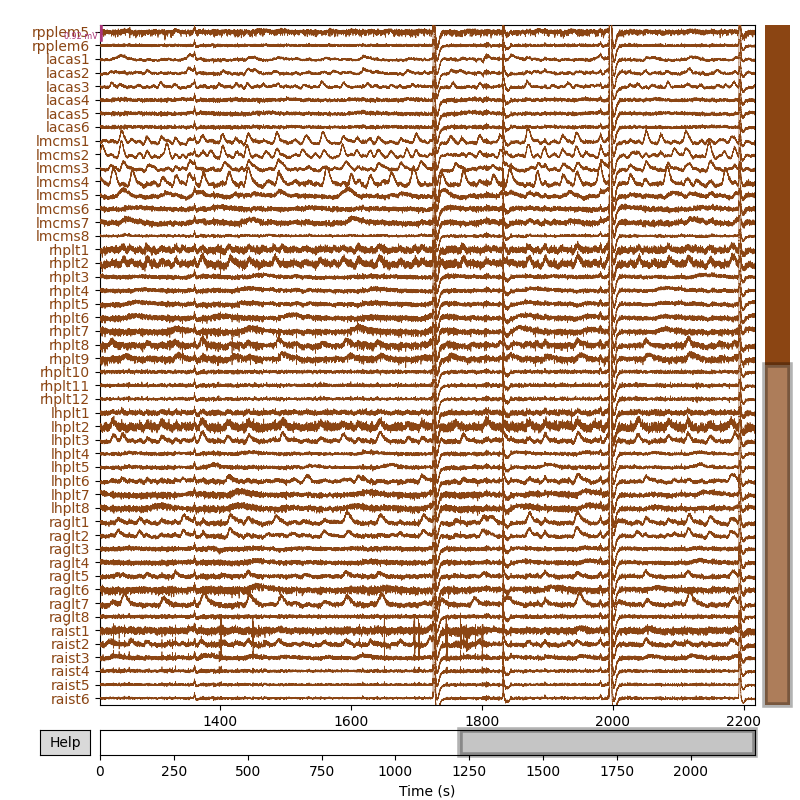

In [31]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=50, scalings=mne_data._data.max()/10)
# fig.fake_keypress('a')

In [30]:
# mne_data.info['bads'] = ['lhplt1',
#  'lhplt2',
#  'rmcms6',
#  'rhplt1',
#  'rhplt2',
#  'lmolf8',
#  'lmcms4',
#  'lmcms3',
#  'rhplt9',
#  'rhplt8'] #old 02/11/2024

In [49]:
mne_data.info #sanity check that bads info saved

<Info | 9 non-empty values
 bads: []
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 100 sEEG
 custom_ref_applied: False
 dig: 100 items (100 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 14:19:49 UTC
 nchan: 100
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [50]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [51]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=39, n_times=1108438
    Range : 0 ... 1108437 =      0.000 ...  2216.874 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas5-lacas6, lhplt1-lhplt2, lhplt2-lhplt3, lhplt3-lhplt4, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms7-lmcms8, lmolf2-lmolf3, lmolf3-lmolf4, lmolf7-lmolf8, lmolf8-lmolf9, raglt1-raglt2, raglt2-raglt3, raglt4-raglt5, raglt5-raglt6, raglt6-raglt7, raist1-raist2, rhplt1-rhplt2, rhplt2-rhplt3, rhplt3-rhplt4, rhplt8-rhplt9, rhplt9-rhplt10, rmcms1-rmcms2, rmcms2-rmcms3, rmcms5-rmcms6, rpem1-rpem2, rpem2-rpem3, rpem3-rpem4, rpmem1-rpmem2, rppem2-rppem3, rppem3-rppem4, rppem4-rppem5, rppem5-rppem6, rpplem4-rpplem5


In [52]:
mne_data_bp_reref

<RawEDF | MS015_SWB.edf, 39 x 1108438 (2216.9 s), ~329.9 MB, data loaded>

In [53]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas5-lacas6',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms7-lmcms8',
 'lmolf2-lmolf3',
 'lmolf3-lmolf4',
 'lmolf7-lmolf8',
 'lmolf8-lmolf9',
 'raglt1-raglt2',
 'raglt2-raglt3',
 'raglt4-raglt5',
 'raglt5-raglt6',
 'raglt6-raglt7',
 'raist1-raist2',
 'rhplt1-rhplt2',
 'rhplt2-rhplt3',
 'rhplt3-rhplt4',
 'rhplt8-rhplt9',
 'rhplt9-rhplt10',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmcms5-rmcms6',
 'rpem1-rpem2',
 'rpem2-rpem3',
 'rpem3-rpem4',
 'rpmem1-rpmem2',
 'rppem2-rppem3',
 'rppem3-rppem4',
 'rppem4-rppem5',
 'rppem5-rppem6',
 'rpplem4-rpplem5']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


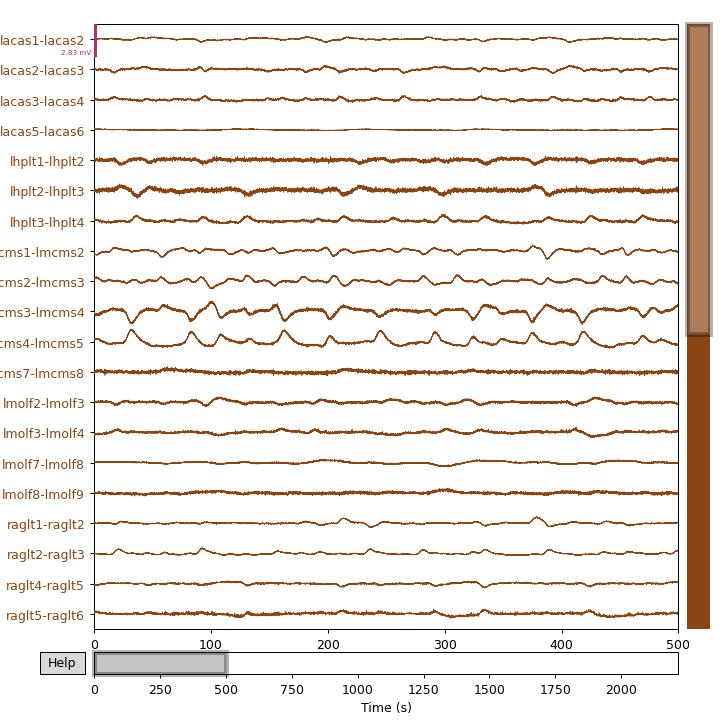

In [10]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=20, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


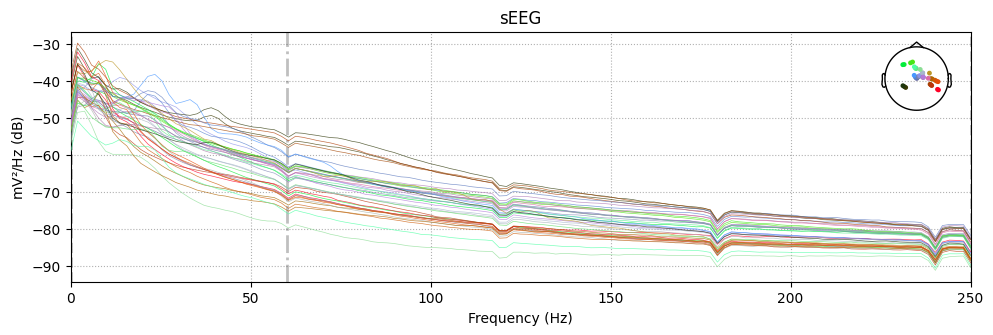

In [54]:
mne_data_bp_reref.compute_psd().plot()


In [55]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/bp_ref_ieeg.fif
[done]


## Save mne_data

In [56]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [57]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [58]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/photodiode.fif...
Isotrak not found
    Range : 0 ... 1108437 =      0.000 ...  2216.874 secs
Ready.
Reading 0 ... 1108437  =      0.000 ...  2216.874 secs...


In [59]:
photodiode_data

<Raw | photodiode.fif, 1 x 1108438 (2216.9 s), ~8.5 MB, data loaded>

In [60]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.7

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 156 pulses


In [61]:
print(slope, offset,smoothSize,windSize,height)

1.0000044309533331 -25.82656688273636 11 15 0.7


In [62]:
#### verify photodiode alignment
    # requires newer functions from new sync utils package (older version used here)

def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts


def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n



In [63]:
pulses = [(x*slope + offset) for x in beh_ts]

# moving_average
neural_ts = get_neural_ts_photodiode(photodiode_data, smoothSize=15, height=0.7)
neural_ts.shape


(156,)

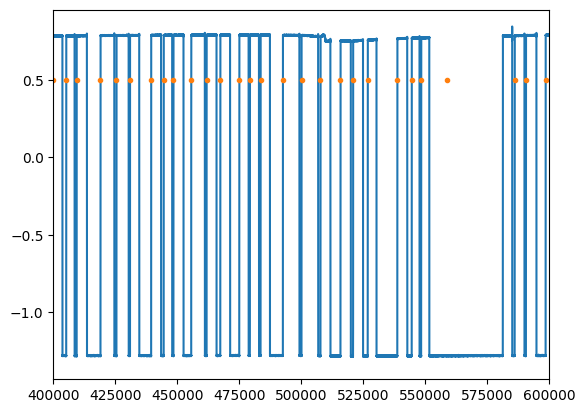

In [70]:

# plt.plot(neural_ts,'o')
# plt.plot(pulses,'o')
# plt.show()

plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
# # plt.plot(pulses)
plt.plot(np.array(pulses)*500, 
         np.ones_like(np.array(pulses)*500)-0.5, '.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([400000,600000])
plt.show()

# temp_diode = photodiode_data.copy()
# temp_diode._data[0,0:1000000] = np.min(temp_diode._data[0,:])
# temp_diode._data[0,3000000:] = np.min(temp_diode._data[0,:])

In [837]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [71]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [72]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [73]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [74]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/bp_ref_ieeg.fif...
    Range : 0 ... 1108437 =      0.000 ...  2216.874 secs
Ready.
Reading 0 ... 1108437  =      0.000 ...  2216.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  36 out of  39 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  36 out of  39 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.2s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 39 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/bp_ref_ieeg.fif...
    Range : 0 ... 1108437 =      0.000 ...  2216.874 secs
Ready.
Reading 0 ... 1108437  =      0.000 ...  2216.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  36 out of  39 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.8s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 39 columns


In [76]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~67.1 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~156.3 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [77]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']


In [78]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 61 columns
Replacing existing metadata with 61 columns


In [79]:
epochs_all_evs[event].metadata

,lacas1-lacas2,lacas2-lacas3,lacas3-lacas4,lacas5-lacas6,lhplt1-lhplt2,lhplt2-lhplt3,lhplt3-lhplt4,lmcms1-lmcms2,lmcms2-lmcms3,lmcms3-lmcms4,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.90,-0.60,-1.90,-0.60,0.00,0.00,1.90,0.60,0.000,-0.950
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.20,-1.10,-2.20,-1.10,0.00,0.00,1.10,0.00,0.000,-1.100
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.75,-0.30,-0.75,-0.30,0.00,0.00,0.45,0.00,0.000,-0.375
3,NaN,NaN,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.42,-0.42,-0.42,-0.42,0.00,0.00,0.42,0.42,0.000,0.000
4,NaN,NaN,NaN,NaN,NaN,NaN,noise,NaN,NaN,NaN,...,3.00,1.50,0.00,0.00,3.00,1.50,-1.50,0.00,1.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.04,-0.80,-1.04,-0.80,0.00,0.00,0.24,0.00,0.000,-0.520
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.39,0.09,0.00,0.00,0.39,0.09,-0.30,0.00,0.195,0.000
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.10,1.10,0.00,0.00,1.10,1.10,-1.10,-1.10,0.000,0.000
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.00,2.40,0.00,0.00,3.00,2.40,0.00,0.60,1.500,0.000


### Save raw epoched data 

In [80]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [81]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [82]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [83]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [84]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [85]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 39, ~670.9 MB>}

In [86]:
power_epochs = {}

In [87]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


Not setting metadata
Adding metadata with 61 columns


In [88]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 39, ~3.27 GB>

In [89]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [90]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

04072024


In [159]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

In [ ]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()


-25.82656688273636
